# Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np

import time
import sys

# Training data

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))])

trainset = datasets.MNIST('~/.pytorch/MNIST_data', download=True, train=True, transform=transform)
testset = datasets.MNIST('~/.pytorch/MNIST_data', download=True, train=False, transform=transform)

# Train and validation split
valid_size = 0.2
valid_index = np.random.choice(range(len(trainset)), int(valid_size*len(trainset)))
train_index = [i for i in range(len(trainset)) if i not in valid_index]
np.random.shuffle(train_index)

train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_index)
valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(valid_index)

# Data loader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, sampler=train_sampler)
validloader = torch.utils.data.DataLoader(trainset, batch_size=64, sampler=valid_sampler)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

### Visualize
Visualize sample images in a batchs.

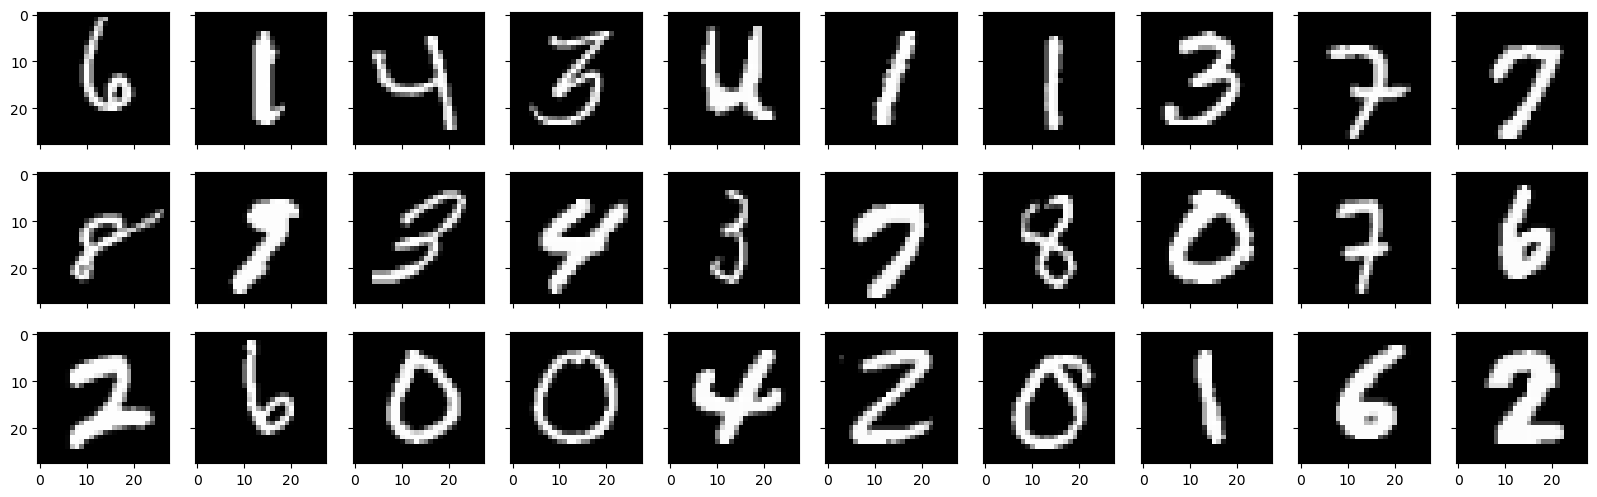

In [3]:
train_images, train_labels = next(iter(trainloader))
valid_images, valid_labels = next(iter(validloader))
test_images, test_labels = next(iter(testloader))

fig, ax = plt.subplots(3,10, figsize=(20,6), dpi=100, sharex=True, sharey=True)
for i in range(ax.shape[1]):
    ax[0,i].imshow(train_images[i,0,:,:], cmap='gray')
    ax[1,i].imshow(valid_images[i,0,:,:], cmap='gray')
    ax[2,i].imshow(test_images[i,0,:,:], cmap='gray')
plt.show()

# Model
Use a neural network with three hidden layers with 256, 128 and 64 hidden units, respectively.
Input images have a shape of 28 x 28, therefore, input size = 28x28 = 784.
Output size is 10 because of 10 digits.

In [4]:
input_size = 784
hidden_sizes = [512, 512]
output_size = 10
units = [input_size] + hidden_sizes + [output_size]

# Define model in pytorch
model = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(units[0], units[1])),
    ('relu1', nn.ReLU()),
    ('droput1', nn.Dropout(p=0.2)),
    ('fc2', nn.Linear(units[1], units[2])),
    ('relu2', nn.ReLU()),
    ('dropout2', nn.Dropout(p=0.2)),
    ('fc3', nn.Linear(units[2], units[3])),
    ('log-softmax', nn.LogSoftmax(dim=1))
]))
print(model)

# Use negative log-likelihood loss and SGD optimizer.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

Sequential(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (relu1): ReLU()
  (droput1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (log-softmax): LogSoftmax()
)


# Training and validation

In [5]:
def compute_accurcay(logps, labels):
    ps = torch.exp(logps)
    _, pred_labels = ps.topk(1, dim=1)
    pred_labels = pred_labels.view(*labels.shape)
    equals = (pred_labels == labels).float()
    return float(torch.mean(equals))

In [6]:
def train_nn(model, trainloader, validloader, n_epochs=1):
    # Send model to GPU(s), if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
    model.to(device)
    
    # Initialize losses and accuracies
    train_losses, valid_losses = [], [] # Train and test losses
    train_accs, valid_accs = [], [] # Train and test accuracies
    min_valid_loss = np.infty
    history = {}
    
    for iepoch in range(n_epochs):
        '''Training'''
        train_loss, train_acc = 0, 0
        for itrain, (images, labels) in enumerate(trainloader):
            images = images.view(images.shape[0],-1)
            # Display progress
            progress_percent = (itrain+1)/len(trainloader)*100
            progress_bar = ['.']*int(progress_percent/(len(trainloader)/100))
            
            sys.stdout.write('\rEpoch: {}/{}..'.format(iepoch+1, n_epochs) \
                             +'Progress: {:0.2f}%..'.format(progress_percent))
            sys.stdout.flush()
            
            # Send data to device (GPU is available, CPU else)
            images, labels = images.to(device), labels.to(device)
            
            # Model training
            logps = model(images) # Forward pass
            loss = criterion(logps, labels)
            optimizer.zero_grad() # Refresh gradient for backpropagation
            loss.backward() # Backpropagation
            optimizer.step() # Update parameters
            
            # Accumulate loss and accuracy for every batch
            train_loss += loss.item()
            train_acc += compute_accurcay(logps, labels)
        # Record losses and accuracies for every epoch
        train_losses.append(train_loss/len(trainloader))
        train_accs.append(train_acc/len(trainloader))

        '''Validation'''
        valid_loss, valid_acc = 0, 0
        with torch.no_grad():
            model.eval() # Disable dropout (if any) for prediction
            for images, labels in testloader:
                images = images.view(images.shape[0],-1)
                # Send data to GPU or CPU
                images, labels = images.to(device), labels.to(device)
                # Predict class probabilities and loss
                logps = model(images)
                loss = criterion(logps, labels)
                # Accumulate loss and accuracy
                valid_acc += compute_accurcay(logps, labels)
                valid_loss += loss.item()
        # Record losses and accuracies
        valid_losses.append(valid_loss/len(testloader))
        valid_accs.append(valid_acc/len(testloader))
        
        # Save model if current epoch gives minimum validation loss
        if valid_losses[iepoch] < min_valid_loss:
            history['model'] = model
        
         # Back to train mode by enabling dropout
        model.train()

        print('Training:',
              '(Loss={:0.3f},'.format(train_losses[iepoch]),
              'Accuracy={:0.3f})..'.format(train_accs[iepoch]),
              'Validation:',
              '(Loss={:.03f},'.format(valid_losses[iepoch]),
              'Accuracy={:0.3f})'.format(valid_accs[iepoch])
             )
    history['train_losses'] = train_losses
    history['valid_losses'] = valid_losses
    history['train_accs'] = train_accs
    history['valid_accs'] = valid_accs
    return history

In [7]:
tstart = time.time()
history = train_nn(model, trainloader, validloader, n_epochs=50)
tend = time.time()
print('Training time: ', tend - tstart)

Epoch: 1/50..Progress: 100.00%..Training: (Loss=1.081, Accuracy=0.714).. Validation: (Loss=0.467, Accuracy=0.860)
Epoch: 2/50..Progress: 100.00%..Training: (Loss=0.432, Accuracy=0.875).. Validation: (Loss=0.332, Accuracy=0.905)
Epoch: 3/50..Progress: 100.00%..Training: (Loss=0.354, Accuracy=0.897).. Validation: (Loss=0.288, Accuracy=0.918)
Epoch: 4/50..Progress: 100.00%..Training: (Loss=0.314, Accuracy=0.908).. Validation: (Loss=0.260, Accuracy=0.924)
Epoch: 5/50..Progress: 100.00%..Training: (Loss=0.281, Accuracy=0.918).. Validation: (Loss=0.235, Accuracy=0.929)
Epoch: 6/50..Progress: 100.00%..Training: (Loss=0.255, Accuracy=0.925).. Validation: (Loss=0.214, Accuracy=0.937)
Epoch: 7/50..Progress: 100.00%..Training: (Loss=0.232, Accuracy=0.932).. Validation: (Loss=0.198, Accuracy=0.942)
Epoch: 8/50..Progress: 100.00%..Training: (Loss=0.213, Accuracy=0.938).. Validation: (Loss=0.180, Accuracy=0.946)
Epoch: 9/50..Progress: 100.00%..Training: (Loss=0.197, Accuracy=0.943).. Validation: (Lo

# Training history

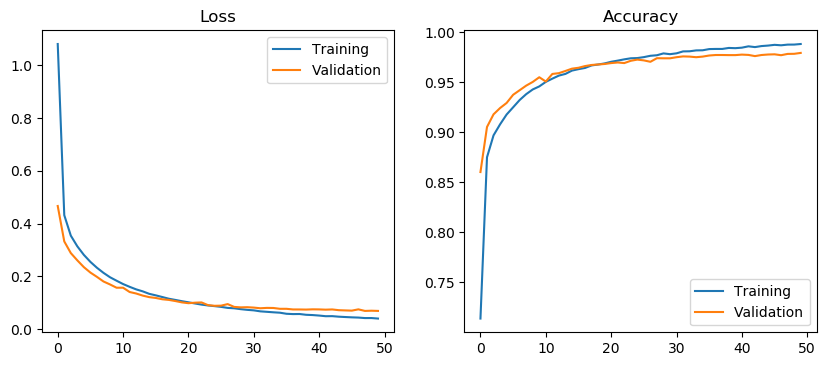

In [8]:
fig, ax = plt.subplots(1,2, figsize=(10,4), dpi=100)
ax[0].plot(history['train_losses'], label='Training')
ax[0].plot(history['valid_losses'], label='Validation')
ax[0].legend()
ax[0].set_title('Loss')

ax[1].plot(history['train_accs'], label='Training')
ax[1].plot(history['valid_accs'], label='Validation')
ax[1].legend()
ax[1].set_title('Accuracy')

plt.show()

# Test accuracy

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = history['model']
model.to(device)

with torch.no_grad():
    acc = 0
    model.eval() # Disable dropout (if any) for prediction
    for images, labels in testloader:
        images = images.view(images.shape[0],-1)
        # Send data to GPU or CPU
        images, labels = images.to(device), labels.to(device)
        # Predict class probabilities and loss
        logps = model(images)
        acc += compute_accurcay(logps, labels)
    accuracy = acc / len(testloader)
print('Test accuracy: {:0.2f}%'.format(accuracy*100))

Test accuracy: 97.91%


# Visualize sample test predictions

In [10]:
def predict(model, testloader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    images, labels = next(iter(testloader))
    flat_images = images.view(images.shape[0],-1)
    
    # Send data and model to GPU or CPU
    flat_images, labels = flat_images.to(device), labels.to(device)
    model.to(device)
    model.eval() # Disable dropout (if any) for prediction
    
    with torch.no_grad():
        logps = model(flat_images) # log probabilities
    ps = torch.exp(logps) # probabilities
    pred_classes = ps.topk(1,dim=1)[1]
    pred_classes = pred_classes.view(*labels.shape)
    pred_classes = pred_classes.to('cpu').numpy()
    labels = labels.to('cpu').numpy()
        
    fig, ax = plt.subplots(1,10, figsize=(20,2), dpi=100, sharex=True, sharey=True)
    for i in range(10):
        ax[i].imshow(images[i,0,:,:], cmap='gray')
        ax[i].set_title('Prediction: '+str(pred_classes[i]) + '/' + str(labels[i]))
    return pred_classes

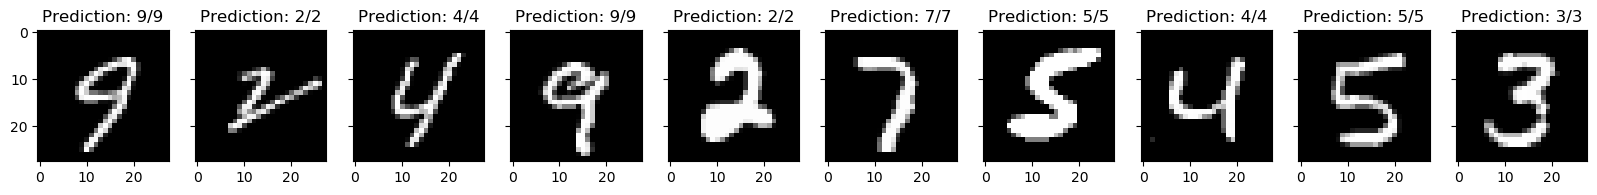

In [11]:
model = history['model']
pred_classes = predict(model, testloader)